<h3>Import packages</h3>

In [49]:
from datetime import date
from timeit import default_timer as timer
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import imagenet_utils
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
#Configure TensorFlow to use GPU for training
tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
#Set GPU memory limit so my GPU doesn't crash
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


<h3>Create class to record time taken to train the model</h3>

In [51]:
#class to record time taken to train per epoch
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

<h3>Create train and test folder</h3>

In [52]:
#creates a folder each time the set of code is run to sort dataset into train and test
day = date.today()
formatDate = day.strftime("%b-%d-%Y")

#create folder with current date to group predictions ran in a day together, if it does not exists
if os.path.isdir('Prediction (' + formatDate + ')') is False:
    folder = os.mkdir('Prediction (' + formatDate + ')')
folder = 'Prediction (' + formatDate + ')'

#looping through to find if destination folder exists
i = 1
while True:
    if os.path.isdir(folder + '/dataset_6 - ' + str(i)) is False:
        break
    i += 1

#destination path for unsorted folder
destination = folder + '/dataset_6 - ' + str(i)

#source path for unsorted folder
source = 'dataset_6/'

#duplicate the unsorted folder from source to destination
shutil.copytree(source, destination)

os.mkdir(destination + '/train')
os.mkdir(destination + '/test')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ngden\AppData\Local\Temp\ipykernel_16876\3267529728.py", line 24, in <module>
    shutil.copytree(source, destination)
  File "c:\Users\ngden\anaconda3\lib\shutil.py", line 557, in copytree
    with os.scandir(src) as itr:
FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset_6/'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_t

<h3>Sort dataset into train and test folder</h3>

In [53]:
#function to split images into training (80%) and testing (20%) and return both
def split(data):
    num = int(len(data) * 0.8)
    # num = int(len(data) * 0.9) #90/10 split
#     num = int(len(data) * 0.7) #70/30 split
    random.shuffle(data)
    return data[:num], data[num:]

dir = os.chdir(destination)
for category in os.listdir(dir):
    #skip the iteration if folder is "train" or "test"
    skip = ['train', 'test']
    if category in skip:
        continue
    
    shutil.move(f'{category}', 'train')
    #create a subfolder with the same name in test
    os.mkdir(f'test/{category}')

    #get the images in each folder (battery type) for spltting of data into training and testing
    img = os.listdir(f'train/{category}')
    training, testing = split(img)
    
    for file in testing:
        shutil.move(f'train/{category}/{file}', f'test/{category}')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ngden\AppData\Local\Temp\ipykernel_16876\2139053688.py", line 9, in <module>
    dir = os.chdir(destination)
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'Prediction (Jul-15-2023)/dataset_6 - 1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPytho

<h3>Transfer Learning</h3>

In [54]:
#"include_top=False argument" will load a network that excluding the classification layers at the top
mobile = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

In [55]:
mobile.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
for layer in mobile.layers[:-2]:
    layer.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = mobile(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)  

model = keras.Model(inputs, output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 2,360,321
Non-trainable params: 12,354,880
_______________________________________

<h3>Process data</h3>

In [57]:
train_path = 'train'
test_path = 'test'

#for data augmentation on training data
datagen = ImageDataGenerator( 
    preprocessing_function =tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    # validation_split=0.1, #changes made for 90/10 split
    rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
#     vertical_flip = False,    # randomly flip images
    vertical_flip = True, #include vertical flip for better generalisation
    )  

#takes images from directory path and generates batches of augmented data
train = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    class_mode = 'binary',
    batch_size=32,
    subset='training',
        shuffle = False)

#for validation data
validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input, 
                                        validation_split=0.2)
# validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, 
#                                         validation_split=0.1) #changes made for 90/10 split


validation = validation_batches.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    class_mode = 'binary',
    batch_size=32,
    subset='validation',
        shuffle = False)

#for test data
test = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224,224), class_mode = 'binary', batch_size=32, shuffle=False)

Found 276 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


<h3>Train model</h3>

In [58]:
model.compile(optimizer=Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['binary_accuracy']) #Last best setting
# model.compile(optimizer=Adam(learning_rate=0.006), loss='binary_crossentropy', metrics=['accuracy']) #Last best setting
checkpoint_filepath = './tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_accuracy',
    # monitor='val_accuracy',
    mode='max',
    save_best_only=True) #save best model

#more epochs for better results
result = model.fit(x=train, validation_data=validation, epochs=150, verbose=2, callbacks=[model_checkpoint_callback,cb])

Epoch 1/150
9/9 - 14s - loss: 11.8437 - binary_accuracy: 0.5254 - val_loss: 2.2145 - val_binary_accuracy: 0.5294 - 14s/epoch - 2s/step
Epoch 2/150
9/9 - 3s - loss: 1.8586 - binary_accuracy: 0.5109 - val_loss: 0.6782 - val_binary_accuracy: 0.6765 - 3s/epoch - 382ms/step
Epoch 3/150
9/9 - 3s - loss: 0.6251 - binary_accuracy: 0.6957 - val_loss: 0.5783 - val_binary_accuracy: 0.6765 - 3s/epoch - 353ms/step
Epoch 4/150
9/9 - 4s - loss: 0.5175 - binary_accuracy: 0.7500 - val_loss: 0.5251 - val_binary_accuracy: 0.7353 - 4s/epoch - 390ms/step
Epoch 5/150
9/9 - 3s - loss: 0.4748 - binary_accuracy: 0.7899 - val_loss: 0.5043 - val_binary_accuracy: 0.7500 - 3s/epoch - 381ms/step
Epoch 6/150
9/9 - 3s - loss: 0.4529 - binary_accuracy: 0.8116 - val_loss: 0.4807 - val_binary_accuracy: 0.7647 - 3s/epoch - 386ms/step
Epoch 7/150
9/9 - 3s - loss: 0.4362 - binary_accuracy: 0.8116 - val_loss: 0.5078 - val_binary_accuracy: 0.7941 - 3s/epoch - 375ms/step
Epoch 8/150
9/9 - 3s - loss: 0.4546 - binary_accuracy: 

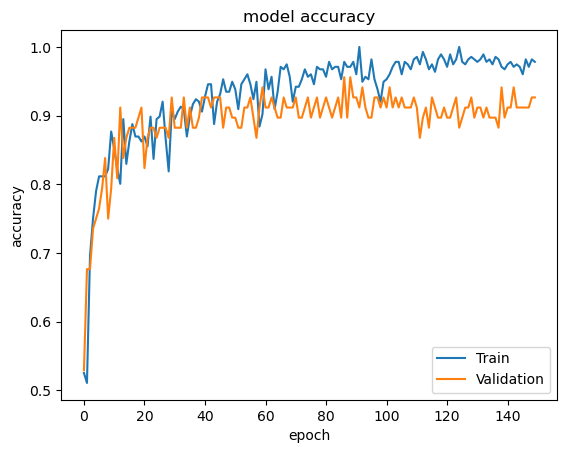

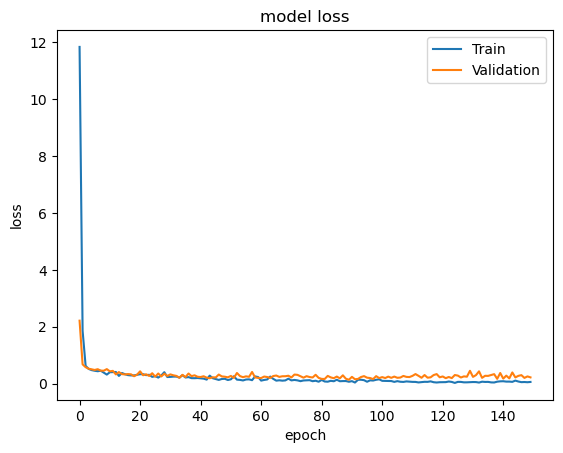

In [59]:
#accuracy
plt.plot(result.history['binary_accuracy'])
plt.plot(result.history['val_binary_accuracy'])
# plt.plot(result.history['accuracy'])
# plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [60]:
# OPTIONAL: Decide if best weights should be loaded from previous model based on val_acc
# The model weights (that are considered the best) are loaded into the model.
result = model.load_weights(checkpoint_filepath)

<h3>Evaluate Test data</h3>

In [61]:
print(sum(cb.logs) / 150)

testLoss, testAcc = model.evaluate(test)
print('''
Test Loss: {}
Test Accuracy: {}
'''.format(testLoss, testAcc))

3.172943977999991
3/3 [==============================] - 4s 2s/step - loss: 0.2794 - binary_accuracy: 0.9302

Test Loss: 0.2794479429721832
Test Accuracy: 0.930232584476471



In [ ]:
#change the directory back to initial path (Image Classification folder)
os.chdir("../..")
# os.listdir()

#save the model
model.save("Models/MobileNetV2/MobileNetV2_covid_classification.h5")

os.chdir(destination)

<h4>*Optional - Fine tune model with two-step training*</h4>

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

mobile.trainable = True

for layer in mobile.layers[:-2]:
    layer.trainable = False
    
#re-train the model at a very low learning rate
model.compile(optimizer=Adam(learning_rate=0.00006), loss='binary_crossentropy', metrics=['binary_accuracy'])

result = model.fit(x=train, validation_data=validation, epochs=100, verbose=2, callbacks=[cb, es])


Epoch 1/100
9/9 - 4s - loss: 0.1230 - binary_accuracy: 0.9493 - val_loss: 0.1771 - val_binary_accuracy: 0.9559 - 4s/epoch - 445ms/step
Epoch 2/100
9/9 - 3s - loss: 0.0745 - binary_accuracy: 0.9783 - val_loss: 0.1956 - val_binary_accuracy: 0.9559 - 3s/epoch - 355ms/step
Epoch 3/100
9/9 - 3s - loss: 0.0751 - binary_accuracy: 0.9783 - val_loss: 0.2160 - val_binary_accuracy: 0.9265 - 3s/epoch - 357ms/step
Epoch 4/100
9/9 - 3s - loss: 0.0559 - binary_accuracy: 0.9928 - val_loss: 0.2076 - val_binary_accuracy: 0.9265 - 3s/epoch - 345ms/step
Epoch 5/100
9/9 - 3s - loss: 0.0645 - binary_accuracy: 0.9674 - val_loss: 0.1963 - val_binary_accuracy: 0.9559 - 3s/epoch - 348ms/step
Epoch 6/100
9/9 - 3s - loss: 0.0735 - binary_accuracy: 0.9783 - val_loss: 0.1926 - val_binary_accuracy: 0.9559 - 3s/epoch - 349ms/step
Epoch 7/100
9/9 - 3s - loss: 0.0736 - binary_accuracy: 0.9783 - val_loss: 0.1664 - val_binary_accuracy: 0.9412 - 3s/epoch - 349ms/step
Epoch 8/100
9/9 - 3s - loss: 0.0429 - binary_accuracy: 

<h3>Accuracy and Loss graph</h3>

In [72]:
#accuracy
plt.plot(result.history['binary_accuracy'])
plt.plot(result.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ngden\AppData\Local\Temp\ipykernel_16876\4012029090.py", line 2, in <module>
    plt.plot(result.history['binary_accuracy'])
AttributeError: 'numpy.ndarray' object has no attribute 'history'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\ultratb.py", line 1319, in 

<h3>Classification report</h3>

In [71]:
predictions = model.predict(test, verbose=0)
# predictions = predictions.reshape(1,-1)[0]
# lst = np.argmax(predictions, axis= 1)
lst = (predictions > 0.5).astype(int)

print(classification_report(test.classes, lst, target_names = test.class_indices))

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ngden\AppData\Local\Temp\ipykernel_16876\4196624631.py", line 1, in <module>
    predictions = model.predict(test, verbose=0)
  File "c:\Users\ngden\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\ngden\anaconda3\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: 'test\\covid\\COVID-1162.png'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ngden\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.Interac

<h3>Confusion matrix</h3>

[[36  0]
 [50  0]]


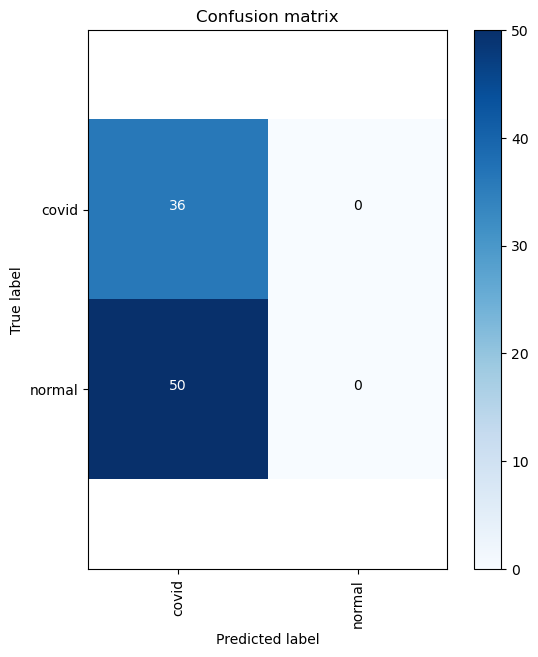

In [65]:
result = confusion_matrix(test.classes, lst)
print(result)

def plot_confusion_matrix(result, classes, cmap=plt.cm.Blues):
    plt.subplots(figsize=(7, 7))
    plt.imshow(result, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

    thresh = result.max() / 2.
    for i, j in itertools.product(range(result.shape[0]), range(result.shape[1])):
        plt.text(j, i, result[i, j],
            horizontalalignment="center",
            color = "white" if result[i, j] > thresh else "black")
        
    #current matplotlib version will cut off top and bottom of the matrix, 
    #hence the manual workaround - remove if matplotlib version does not cut off
    b, t = plt.ylim() # discover bottom and top values
    b += 0.5 # Add 0.5 to bottom
    t -= 0.5 # Subtract 0.5 from top
    plt.ylim(b, t) # update ylim(bottom, top) values
    plt.show()
    
plot_confusion_matrix(result, list(test.class_indices.keys()))

<h3>Save the model</h3>

In [68]:
#change the directory back to initial path (Image Classification folder)
os.chdir("../..")
# os.listdir()

#save the finetuned model so that it can be passed to edge device
model.save("MobileNetV2_covid_classification_finetuned.h5")